# Logistic Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load data
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
# Feature columns
feature_cols = ['statement', 'subject', 'speaker', 'party_affiliation', 'context',
       'subject_count', 'readability_score', 'num_named_entities',
       'entity_types_present', 'has_citation_words',
       'polarity_shift_words_count', 'uncertainty_words_count',
       'negation_words_count', 'tfidf_score_sum', 'sentiment_score']

target_col = 'label_id'

In [4]:
# Split X and y
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

In [5]:
# Define column groups
text_features = ['statement']
categorical_features = ['subject', 'speaker', 'party_affiliation', 'context']
numeric_features = ['subject_count', 'readability_score', 'num_named_entities',
                    'entity_types_present', 'has_citation_words',
                    'polarity_shift_words_count', 'uncertainty_words_count',
                    'negation_words_count', 'tfidf_score_sum', 'sentiment_score']

In [6]:
# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [7]:
# Build full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        multi_class='multinomial',
        solver='lbfgs',
        random_state=691
    ))
])

In [8]:
# Define param_grid
param_grid = {
    'preprocessor__text__max_features': [5000, 10000, 20000],
    'preprocessor__text__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'lr__C': [0.01, 0.1, 1, 10]
}

In [9]:
# Set up GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='f1_weighted'
)

In [10]:
# Run grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\arabi\miniconda3\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(),
                                                                         'statement'),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['subject',
                                                                          'speaker',
                                                                          'party_affiliation',
                                                                          'context']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['subject_count',
                                                                          'readability_score',
                                                                          'num_named_entities',
                                                                          'entity_types_present',
                                                                          'has_citation_w...
                                                                          'negation_words_count',
                                                                          'tfidf_score_sum',
                                                                          'sentiment_score'])])),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=691))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1, 10],
                         'preprocessor__text__max_features': [5000, 10000,
                                                              20000],
                         'preprocessor__text__ngram_range': [(1, 1), (1, 2),
                                                             (1, 3)]},
             scoring='f1_weighted', verbose=1)

In [11]:
# Best params
print("Best parameters:", grid.best_params_)

Best parameters: {'lr__C': 0.1, 'preprocessor__text__max_features': 5000, 'preprocessor__text__ngram_range': (1, 2)}


In [12]:
# Best estimator
best_model = grid.best_estimator_

In [13]:
# === Evaluate on validation set ===
y_val_pred = best_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.2850467289719626
Validation Report:
               precision    recall  f1-score   support

           0       0.31      0.48      0.38       116
           1       0.27      0.27      0.27       263
           2       0.29      0.27      0.28       237
           3       0.35      0.20      0.25       248
           4       0.31      0.31      0.31       251
           5       0.21      0.29      0.25       169

    accuracy                           0.29      1284
   macro avg       0.29      0.30      0.29      1284
weighted avg       0.29      0.29      0.28      1284



In [14]:
# Plot confusion matrix (validation)
cm_val = confusion_matrix(y_val, y_val_pred)
label_names = train_df[['label_id', 'label']].drop_duplicates().sort_values('label_id')['label'].tolist()

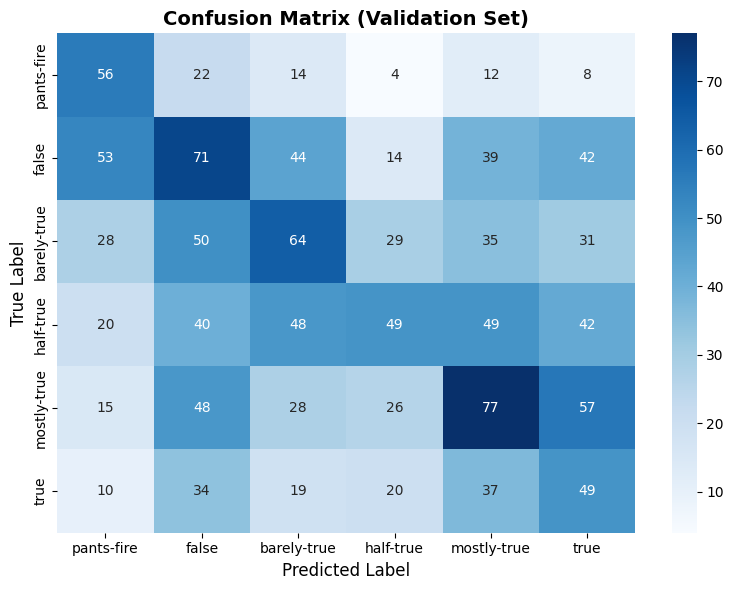

In [15]:
# Raw CM - Validation
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)

plt.title('Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix_validation_raw.png', dpi=300)
plt.show()

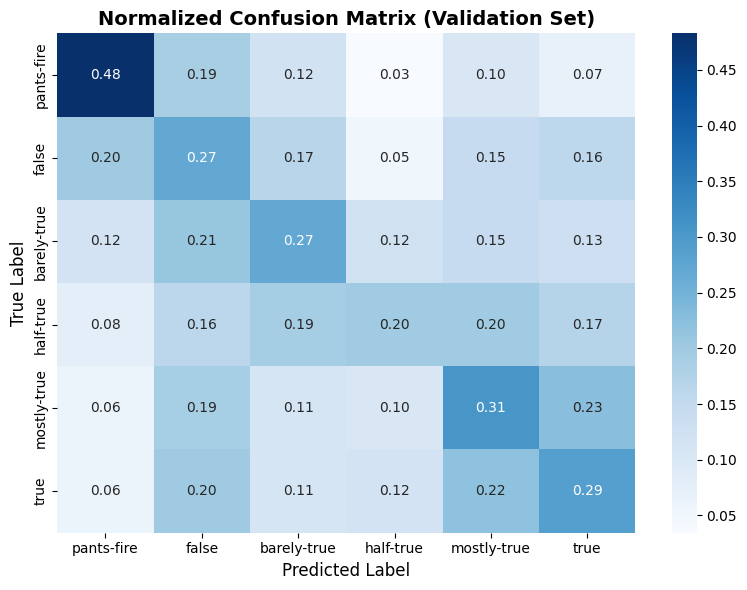

In [16]:
# Normalized CM - Validation
cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)

plt.title('Normalized Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix_validation_normalized.png', dpi=300)
plt.show()

In [17]:
# === Evaluate on test set ===
y_test_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Report:\n", classification_report(y_test, y_test_pred))

Test Accuracy: 0.26045777426992894
Test Report:
               precision    recall  f1-score   support

           0       0.23      0.37      0.29        92
           1       0.26      0.27      0.27       249
           2       0.23      0.20      0.22       212
           3       0.27      0.16      0.20       265
           4       0.28      0.28      0.28       241
           5       0.27      0.37      0.31       208

    accuracy                           0.26      1267
   macro avg       0.26      0.27      0.26      1267
weighted avg       0.26      0.26      0.26      1267



In [18]:
# Plot confusion matrix (test)
cm_test = confusion_matrix(y_test, y_test_pred)

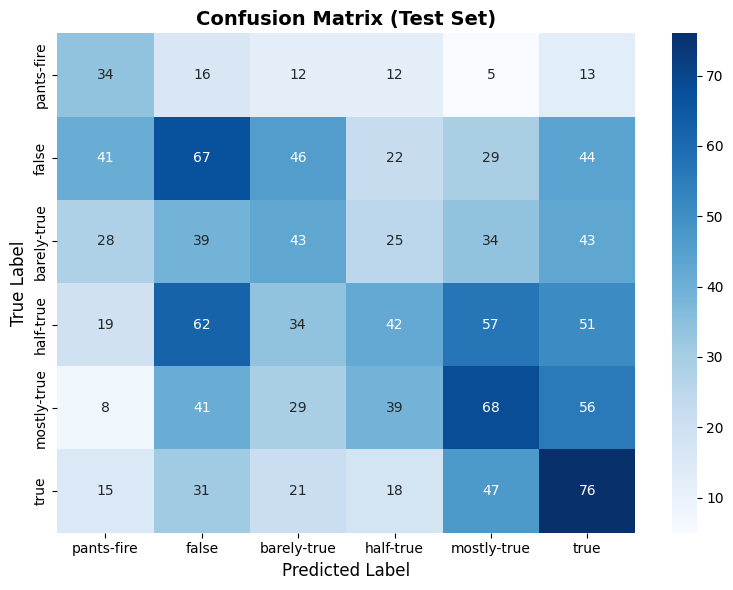

In [19]:
# Raw CM - Test
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)

plt.title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix_test_raw.png', dpi=300)
plt.show()

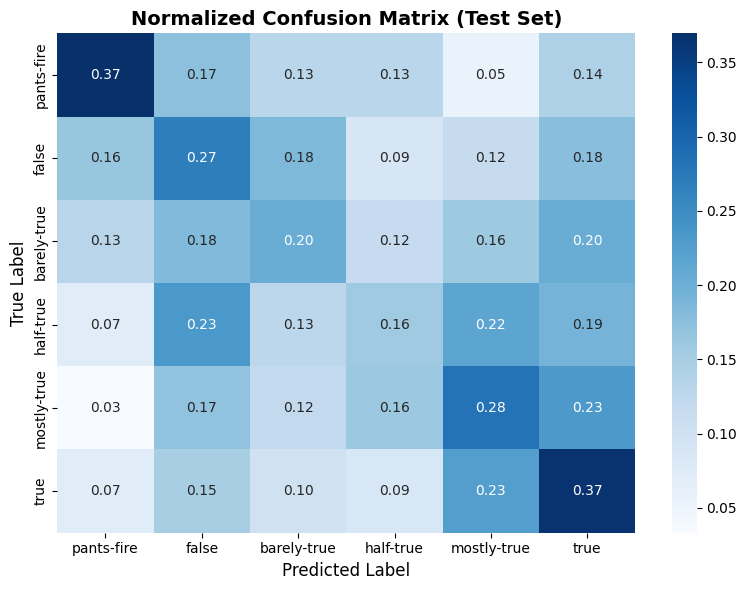

In [20]:
# Normalized CM - Test
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)

plt.title('Normalized Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix_test_normalized.png', dpi=300)
plt.show()

---